## Memorize Kth number in a sequence of numbers ##

This being the first problem in the RNN lab, we would start with a toy example, which is quick to train and easy to understand. What we got to do is to train a recurrent network to always remember the number appearing in a particular position in any sequence of integers.

Below examples show few cases where the number to be remembered is at position 2

`6,9,8,1,8,3,4  -- > 9`<br>
`1,2,3,4 --> 2`<br>
`9,7,2,3,4,5,6,1,1,1 -- > 7`<br>

### Overview ###


This exercise is planned as below:

       1. First, we we discuss how the integers are represented 
       2. Then we see how the input and outputs to the network look like
       3. We set up the RNN network and define how the forward pass mus be done
       4. We explore the memory retention abilities of a vanilla RNN vs an LSTM or GRU

In [1]:
# coding: utf-8
# =============================================================================
# Make an RNN output kth integer in a sequence of N integers ( N > k)
# Sequences could be of any length

# ==============================================================================


%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from time import sleep
import random
import sys
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
random.seed( 10 ) # set the random seed (for reproducibility)

## Preparing the Training Data ##

###   Random sequences of integers in [0-9] range are generated as training data###
The function `getSample` below takes a sequence length `seqL` as input and returns a training sample to be fed to the RNN.


For a given length `seqL`, a training sample is a 2-tuple of input -$x$ and output -$y$ where

* `input` is a tensor of size [`seqLx1x10`]:<br>
	* Second dimension is the batch size, Third dimension is 10 since each integer is represented as a one-hot vector of dimension=10 (since we in this case consider only sequence of integers in [0-9]


* `output` is just a single number . Its the number at the Kth position which need to be remembered. So $y$ is a tensor with just one element

In [2]:
def getSample(seqL,k,testFlag=False):
    #returns a random sequence of integers of length = seqL
    kthInt=0
    x =  torch.zeros(seqL,10)
    for i in range(0,seqL):
        randomIntegerNumber = random.randint(0,9)
        if i==k-1:
            kthInt=randomIntegerNumber
        if testFlag:
            sys.stdout.write(str(randomIntegerNumber) + ' ')
        x[i,randomIntegerNumber-1] = 1

    if testFlag:
            sys.stdout.write('--> ' + str(kthInt) + '\n')
    x=x.unsqueeze(1) #extra dimension for Batch
    y=torch.tensor([kthInt]) #target is the number at kth position in the sequence 

    return x,y
        

### Model Input ###
As noted above, the inputs are `seqLx10` dimensional tensors, where first row corresponds to the first number in the sequence and last row is for the last number in the sequence. And within a row, the values are zero except for column where $columnIndex == j-1$, where $j$ the position of the number we need to memorize
The `input` rows are fed  one-by-one, starting from the top, proceeding all the way to the last row.<br>
Hence at each   `timestep` the input to the network is of a dimension=10<br>
__Note__: This is not shown explicitly in the provided code, but is done internally. ie, RNN unrolling for a sequence is handled internally, we need not explicity loop through the timesteps.



### Model Output  ###
At the last timestep, the model should output the number at position $k$. For this purpose we have an output layer of 10 neurons. Each corresponding to integers 0-9. So if the $k^{th}$ integer is say 7, then the 7th neuron should fire the most. Or in other words output of this node should have the maximum value . 


## Training Loss ##
We use the `CrossEntropy Loss'  to compare the predicted value $y_t$, and the target $\tilde{y_t}$:



__Note__: The loss is computed only at the last time step.

The image below shows a schematic of the "unrolled" RNN in our case. For the ease of visualizing we show only two hidden units. In practice it could be more:

In the picture $\tilde{y_t}$ is [1,0,0,0,0,0,0,0,0,0] since the required number is 0

![network architecture](static/KthNo_architecture.jpg)


## Model Implementation ##
The following class `Memorize` implements the above RNN. We only give the forward-pass implementation.
The backward pass is calcuated automatically by PyTorch's auto-grad.

The only parameters passed to the model is the size (dimensionality) of the hidden state.
Bigger state, means higher capacity.


In [3]:
class Memorize (nn.Module):
    def __init__(self,stateDim):
        super(Memorize, self).__init__()
        self.stateDim = stateDim
        self.inputDim = 10  # integer is represented as 1 hot vector of dimension=10
        self.outputDim = 10  # 10 nodes for 10 classes
        # currently the model uses the 'LSTM' cell. You could try
        # others like: tanh, GRU. See: https://github.com/pytorch/examples/blob/master/word_language_model/model.py#L11
        self.lstm = nn.LSTM(self.inputDim, self.stateDim )
        self.outputLayer = nn.Linear(self.stateDim, self.outputDim)
        self.softmax = nn.Softmax()
        

    def forward(self, x):
        """
        X: [L,B,inputDim(=10)] dimensional input tensor
            L: Sequence length
            B: is the "batch" dimension. As we are training on 
               single examples, B = 1 for us.
        """
        lstmOut,_ = self.lstm(x)
        L,B,D  = lstmOut.size(0),lstmOut.size(1),lstmOut.size(2) # L is seq len, B is batch size and D is feature dimension
        #lstmOut holds the outputs at all timesteps but we require  only the output at last time step (L-1)
        lstmOut_lastTimeStep = lstmOut[L-1,0,:]
        #print (lstmOut_lastTimeStep.size())
        
        #lstmOut = lstmOut.view(L*B,D)
        outputLayerActivations = self.outputLayer(lstmOut_lastTimeStep)
        #outputSoftMax=self.softmax(outputLayerActivations)
        # project lstm states to "output"
        
    
        return outputLayerActivations.unsqueeze(0)

### Training the Network ###

Please see the beginning of the below code snippet, to change $k$ and seqLs of training samples<br>

The model is trained on sequencess of lengths in range of `minSeqLength` and `maxSeqLength`

For simplicity, training code runs for a fixed number of epochs (or iterations). In practice, the training should be monitored with performance on a held-out or validation set, in order to avoid over-fitting.

In the below training code the training runs for `min_epochs` and in each epoch 500 samples (== `iterations`) are fed. And remember that the loss is calculated for each sample and then backprop() is called. This is in contrast to batch learning where weights are updated after feeding in a bacth of samples. In our case there is no batching or batchSize =1

We use the [`Adam` optimizer](https://arxiv.org/abs/1412.6980).

The model runs fast enough to train on the CPU itself (GPUs are not used).

Lets train our first RNN model!

Model initialized
[epoch 1/20] Avg. Loss for last 500 samples = inf


/home/manisha.padala/env3/lib/python3.5/site-packages/ipykernel_launcher.py:39: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


[epoch 2/20] Avg. Loss for last 500 samples = 2.275295
[epoch 3/20] Avg. Loss for last 500 samples = 2.104760
[epoch 4/20] Avg. Loss for last 500 samples = 1.941874
[epoch 5/20] Avg. Loss for last 500 samples = 1.009855
[epoch 6/20] Avg. Loss for last 500 samples = 0.110483
[epoch 7/20] Avg. Loss for last 500 samples = 0.012220
[epoch 8/20] Avg. Loss for last 500 samples = 0.004849
[epoch 9/20] Avg. Loss for last 500 samples = 0.002744
[epoch 10/20] Avg. Loss for last 500 samples = 0.001711
[epoch 11/20] Avg. Loss for last 500 samples = 0.001045
[epoch 12/20] Avg. Loss for last 500 samples = 0.000705
[epoch 13/20] Avg. Loss for last 500 samples = 0.000516
[epoch 14/20] Avg. Loss for last 500 samples = 0.000385
[epoch 15/20] Avg. Loss for last 500 samples = 0.000297
[epoch 16/20] Avg. Loss for last 500 samples = 0.000190
[epoch 17/20] Avg. Loss for last 500 samples = 0.000148
[epoch 18/20] Avg. Loss for last 500 samples = 0.040659
[epoch 19/20] Avg. Loss for last 500 samples = 0.046973


<IPython.core.display.Javascript object>


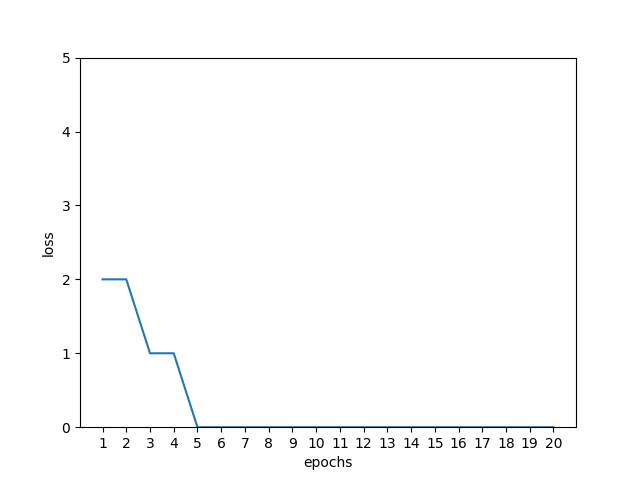

In [7]:
# set here the size of the RNN state:
stateSize = 20
# set here the size of the binary strings to be used for training:
k=2 # we want the RNN to remember the number at 2nd position
minSeqLength = 3
maxSeqLength = 8

## sequenceLengths would be in range in range minSeqLength - maxSeqLength


# create the model:
model = Memorize(stateSize)
print ('Model initialized')

# create the loss-function:
lossFunction = nn.CrossEntropyLoss() # or nn.CrossEntropyLoss() -- see question #2 below

# uncomment below to change the optimizers:
#optimizer = optim.SGD(model.parameters(), lr=3e-2, momentum=0.8)
optimizer = optim.Adam(model.parameters(),lr=0.01)
iterations = 500
min_epochs = 20
num_epochs,totalLoss = 0,float("inf")
lossList = []
while num_epochs < min_epochs:
    print("[epoch %d/%d] Avg. Loss for last 500 samples = %lf"%(num_epochs+1,min_epochs,totalLoss))
    num_epochs += 1
    totalLoss = 0
    for i in range(0,iterations):
        # get a new random training sample:
        sequenceLength = random.randint(minSeqLength,maxSeqLength)
        x,y = getSample(sequenceLength,k)
        model.zero_grad()

        pred = model(x)

        # compute the loss:
        loss = lossFunction(pred,y)
        totalLoss += loss.data[0]
        optimizer.zero_grad()
        # perform the backward pass:
        loss.backward()
        # update the weights:
        optimizer.step()
    totalLoss=totalLoss/iterations
    lossList.append(int(totalLoss))
print('Training finished!')
epochs =  np.arange(1,21)
# plot the loss over epcohs:
plt.plot(epochs,lossList)
plt.xlabel('epochs'); plt.ylabel('loss'); plt.xticks(epochs,epochs)
plt.ylim([0,5]); 



## Testing the Model ###
Lets feed in a sample sequence and see if the network can output the number at the $k^{th}$ position

In [8]:
testSeqL = 6
x,y = getSample(testSeqL,k,testFlag=True)

pred = model(x)
ind=  torch.argmax(pred)
print ( 'number at kth position is ',int(ind))

1 0 8 5 4 2 --> 0
number at kth position is  0


__Question 1:__  

Above testing code snippet is  only for one sample. Test 500 samples of random seqLens in [3,7] range and compute the average accuracy

__Question 2:__  Use vanilla RNN instead of the LSTM in the model and do the following
  1. plot the epochs vs loss like in the above case when vanilla RNN is used (without changing `k`, `stateSize`, `minSeqL` and `maxSeqL`)
  2. Make  `minSeqL` and `maxSeqL` = 10 and  `k`=9 and repeat the experiment with vanilla RNN
  3. Make  `minSeqL` and `maxSeqL` = 3 and  `k`=2 and repeat the experiment with vanilla RNN

__Question 3:__ 
 Train  on fixed sequence lengths and see if it works for shorter and longer sequences


__Question 4:__  Try MSE ( Mean Square Error) loss instead of CrossEntropy Loss